In [1]:
"""Based off: https://docs.opencv.org/4.0.0/dd/dd7/tutorial_morph_lines_detection.html"""

import numpy as np
import matplotlib.pyplot as plt
import sys
import cv2 as cv

In [2]:
img_path = "./04352.png" # Scanned
# img_path = "./37048.png" # Perfect

(3349, 2488)


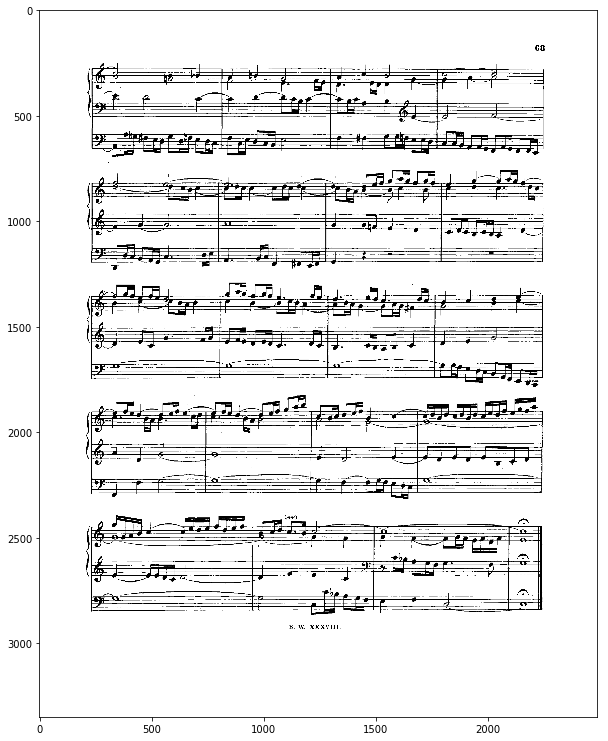

In [3]:
src = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
print(src.shape)
# Show source image
plt.figure(figsize=(10,13))
plt.imshow(src, aspect="auto", cmap = "gray")

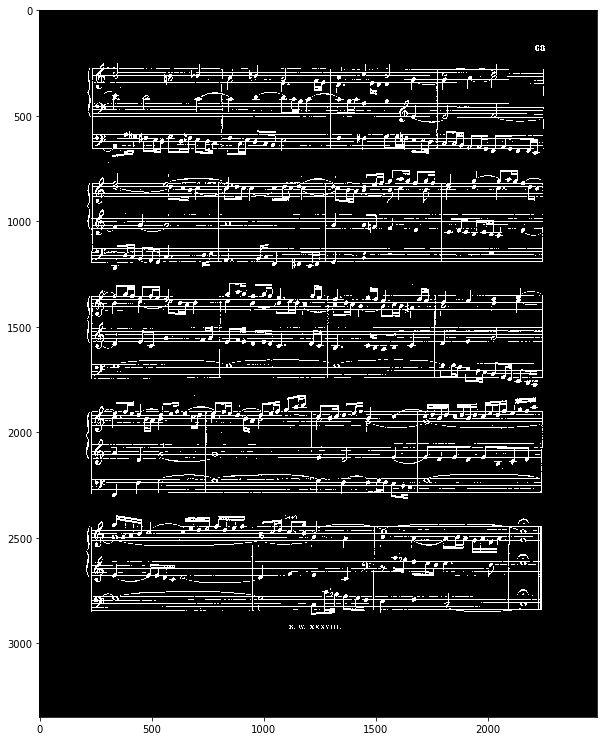

In [4]:
# Convert image to binary
gray = cv.bitwise_not(src)
bw = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, \
                            cv.THRESH_BINARY, 15, -2)
plt.figure(figsize=(10,13))
plt.imshow(bw, aspect="auto", cmap = "gray")

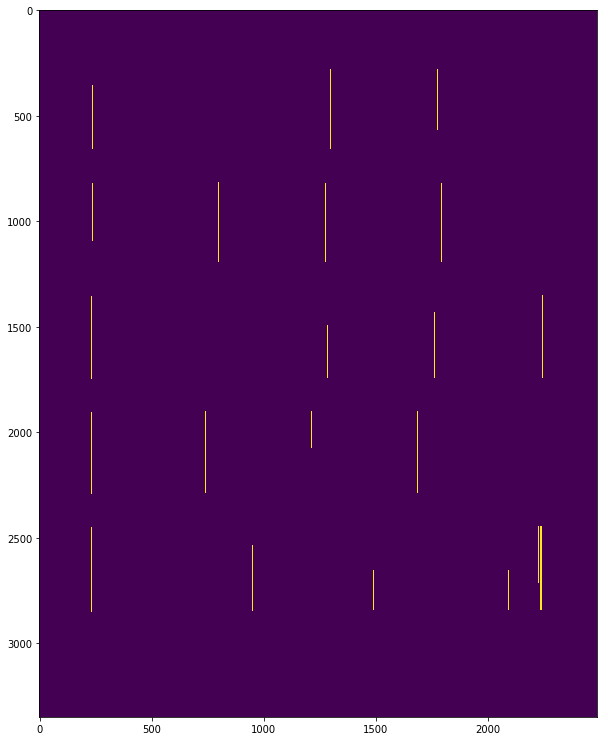

In [5]:
# ----VERTICAL LINE DETECTION----
vertical = np.copy(bw)
# Specify size on vertical axis
rows = vertical.shape[0]
verticalsize = rows // 30
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv.getStructuringElement(cv.MORPH_RECT, (1, verticalsize))
# Apply morphology operations
vertical = cv.erode(vertical, verticalStructure)
vertical = cv.dilate(vertical, verticalStructure)
# Show extracted vertical lines
plt.figure(figsize=(10,13))
plt.imshow(vertical, aspect="auto")

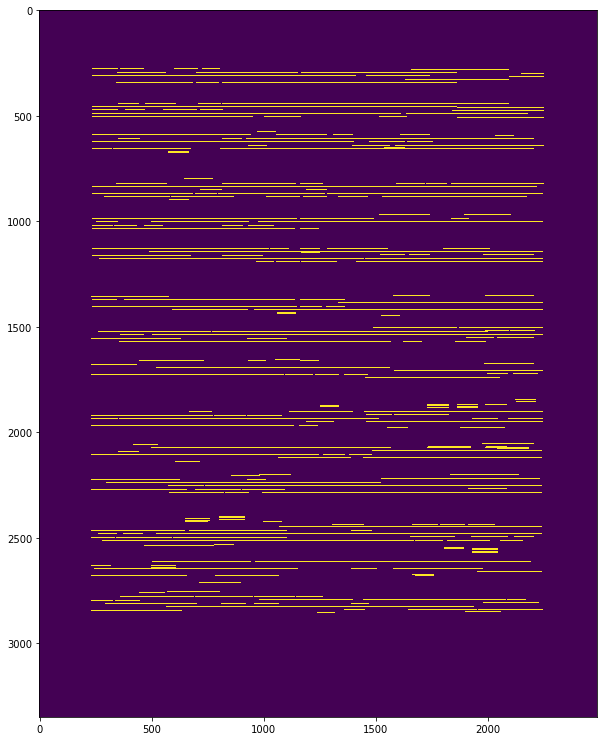

In [6]:
# ---- HORIZONTAL LINE DETECTION ----
horizontal = np.copy(bw)

# [init]
# [horiz]
# Specify size on horizontal axis
cols = horizontal.shape[1]
horizontal_size = cols // 30
# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
horizontal = cv.erode(horizontal, horizontalStructure)
horizontal = cv.dilate(horizontal, horizontalStructure)
plt.figure(figsize=(10,13))
plt.imshow(horizontal, aspect="auto")

In [21]:
cv.imwrite("vert.png", vertical)
cv.imwrite("horiz.png", horizontal)

True

# Line Splitting

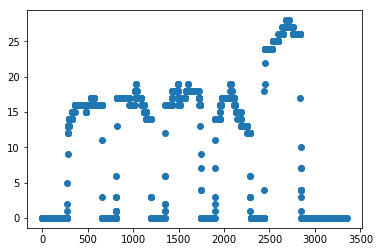

In [8]:
vert_norm = vertical // vertical.max()
horiz_sum_vert = vert_norm.sum(axis=1)
plt.scatter(np.arange(horiz_sum_vert.size), horiz_sum_vert)

In [22]:
def get_split_indices(array, comparator=(lambda x: x == 0)):
    '''Input: 1-D array of indicies of zeros of horizontal summation
    Output: Iterator of indicies to split images by discontinuities in zeros'''
    indices = np.where(comparator(array))[0]
    # we dont want to add 1 to last element
    for i in range(indices.size - 1):
        if indices[i+1] - indices[i] != 1:
            yield (indices[i], indices[i+1])

In [23]:
line_pairs = list(get_split_indices(horiz_sum_vert))
line_pairs

[(275, 660), (810, 1198), (1347, 1746), (1896, 2292), (2443, 2851)]

In [24]:
def get_split_indices_average(array):
    '''Input: 1-D array of indicies of zeros of horizontal summation
    Output: Iterator of indicies to split image at by average of zeros'''
    line_pair = list(get_split_indices(array))
    line_pair = [(0, 0)] + line_pair + [(array.size, array.size)]
    for i in range(len(line_pair) - 2):
        a = line_pair[i][1]
        b = line_pair[i+1][0]
        a1 = line_pair[i+1][1]
        b1 = line_pair[i+2][0]
        yield ( a + ((b-a)//2) , a1 + ((b1-a1)//2))

In [25]:
line_cuts = list(get_split_indices_average(horiz_sum_vert))
line_cuts

[(137, 735), (735, 1272), (1272, 1821), (1821, 2367), (2367, 3100)]

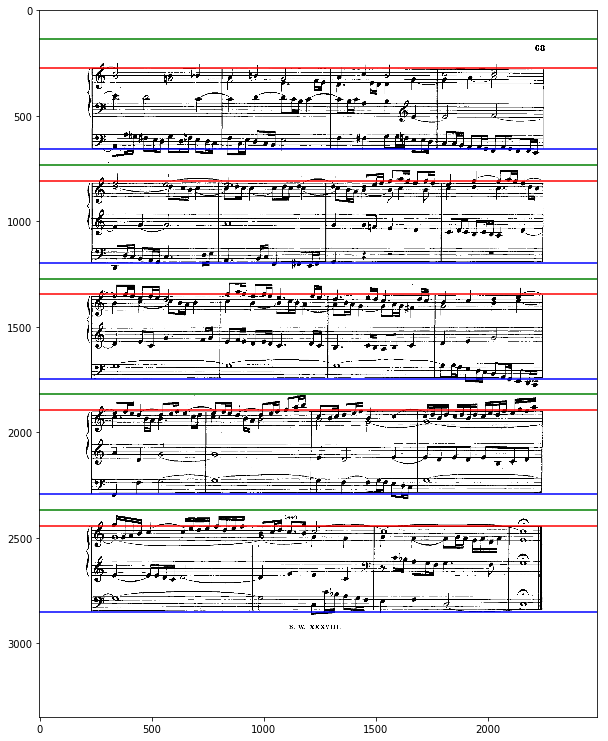

In [26]:
plt.figure(figsize=(10,13))
plt.imshow(src, aspect="auto", cmap = "gray")
for start, end in line_pairs:
    plt.axhline(y=start, color = 'r')
    plt.axhline(y = end, color = 'b')
for cut in line_cuts:
    plt.axhline(y=cut[0], color = 'g')
# Note: This does not show the last green cut.

In [34]:
def cut_array(array, positions, direction="H"):
    '''Input: array: image array, positions: array of start end tuples
       Output: array of image arrays cut by positions'''
    for start , end in positions:
        if (direction == "H"):
            yield array[start:end, :]
        else: 
            yield array[:, start:end]

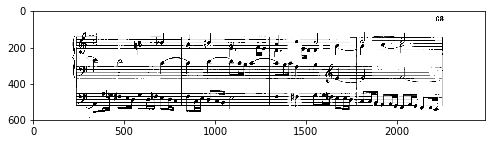

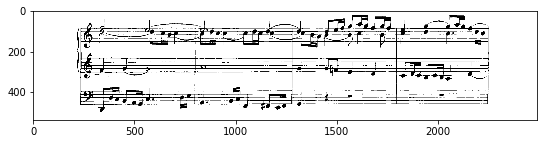

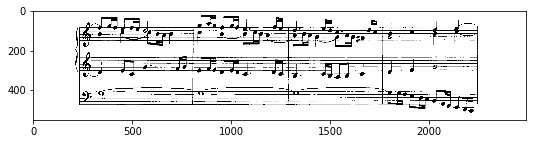

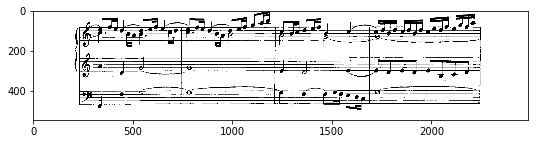

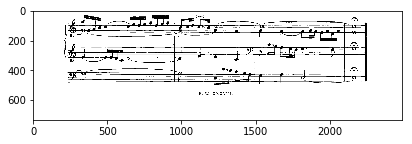

In [30]:
array_of_cuts = list(cut_array(src, line_cuts))
for i, cut in enumerate(cut_array(src, line_cuts)):
    plt.figure(figsize = (10,2))
    plt.imshow(cut, cmap="gray")
    cv.imwrite("./cuts/"+img_path +"_cut_"+str(i)+".png", cut)

# Vertical Split

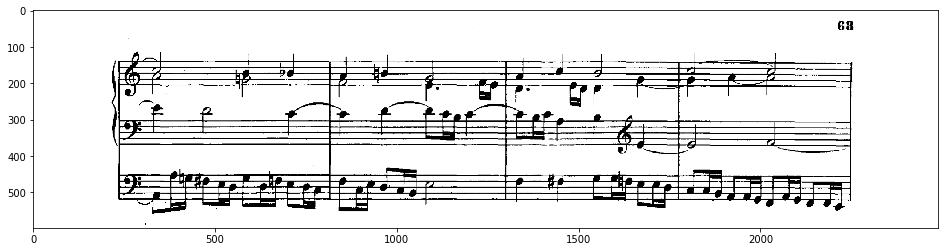

In [35]:
plt.figure(figsize = (20,4))
one_cut = array_of_cuts[0]
plt.imshow(one_cut, cmap="gray")

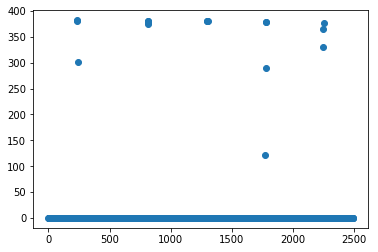

In [36]:
array_of_vert = list(cut_array(vert_norm, line_cuts))
one_vert = array_of_vert[0]
vertical_sum_vert = one_vert.sum(axis=0)
plt.scatter(np.arange(vertical_sum_vert.size), vertical_sum_vert)

In [37]:
bar_lines = list(get_split_indices(vertical_sum_vert, lambda x: x > 0))
bar_lines

[(238, 814), (817, 1298), (1300, 1773), (1776, 2246)]

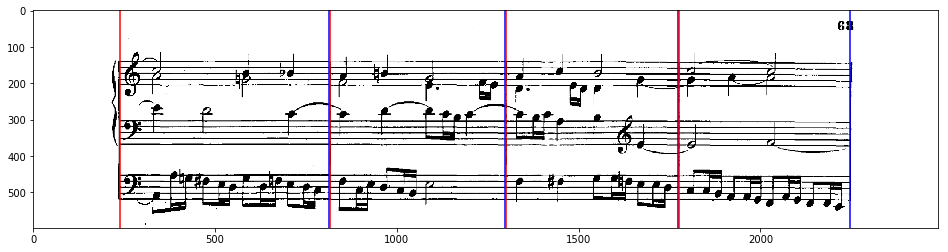

In [38]:
plt.figure(figsize = (20,4))
plt.imshow(array_of_cuts[0], cmap="gray")
for start, end in bar_lines:
    plt.axvline(x = start, color = 'r')
    plt.axvline(x = end, color = 'b')

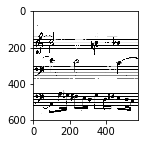

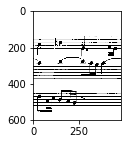

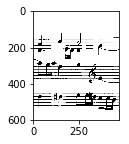

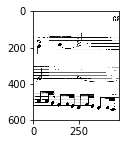

In [42]:
array_of_bars = list(cut_array(one_cut, bar_lines, "V") )
for i, cut in enumerate(array_of_bars):
    plt.figure(figsize = (4,2))
    plt.imshow(cut, cmap="gray")
    cv.imwrite("./cuts/"+img_path +"_bar_cut_"+str(i)+".png", cut)

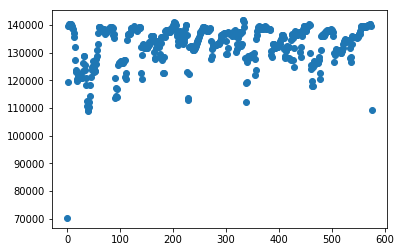

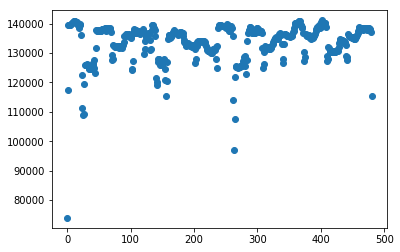

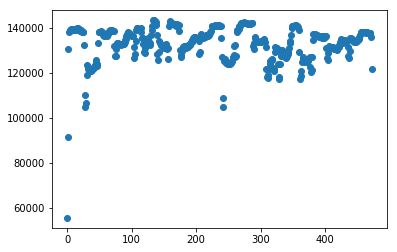

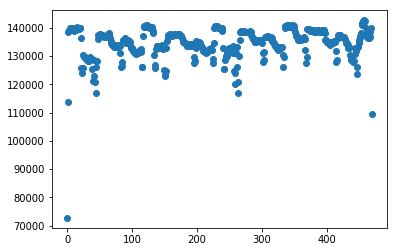

In [45]:
for bar in array_of_bars:
    bar_sum = bar.sum(axis=0)
    plt.figure()
    plt.scatter(np.arange(bar_sum.size), bar_sum)

In [16]:
# MIGHT BE IMPORTANT?
# Extract edges and smooth image according to the logic
# 1. extract edges
# 2. dilate(edges)
# 3. src.copyTo(smooth)
# 4. blur smooth img
# 5. smooth.copyTo(src, edges)
# '''
# # Step 1
# edges = cv.adaptiveThreshold(vertical, 255, cv.ADAPTIVE_THRESH_MEAN_C, \
#                             cv.THRESH_BINARY, 3, -2)
# show_wait_destroy("edges", edges)
# # Step 2
# kernel = np.ones((2, 2), np.uint8)
# edges = cv.dilate(edges, kernel)
# show_wait_destroy("dilate", edges)
# # Step 3
# smooth = np.copy(vertical)
# # Step 4
# smooth = cv.blur(smooth, (2, 2))
# # Step 5
# (rows, cols) = np.where(edges != 0)
# vertical[rows, cols] = smooth[rows, cols]
# # Show final result
# show_wait_destroy("smooth - final", vertical)
# # [smooth]

